# EY NextWave Data Science Competition 2019
This notebook presents the 24th place solution globally (and 1st place solution in the US) for EY NextWave Data Science Competition 2019.

The aim of the competition is to investigate how data can help the next smart city thrive, and boost the mobility of the future. 

I would like to express my gratitude to EY for hosting such an exciting and challenging competition and Skyhook for providing the dataset. It is certainly a great learning experience for me.

# Table of Contents
*   Solution summary
*   Imports
*   Data read-in
*   Feature engineering
*   Labels creation
*   Feature selection
*   Validation strategy
*   Model
*   Feature importance
*   Prediction
*   Challenges
*   What did not work

# Solution summary
The goal of the competition is to predict whether is the exit point of a device within the city center given the entry time. I mainly took the challenge as a binary classification task by creating a label `in_city` to indicated whether is the device in the city centre given an entry point. 

## Week 1 - Public leaderboard: 0.867
I first converted coordinates to latitudes and longitudes and started building a baseline with 45 features including distance, distance-lag, time, time-lag features. To start, validation score aligns with public leaderboard. 

## Week 2 - Public leaderboard: 0.870
I researched for more distance features and started to perform more feature engineering.

## Week 3 - Public leaderboard: 0.888
The moment came when I started to build my `train` and `validation` set differently (more details below).

## Week 4 - Public leaderboard: 0.892
I explored stacking, but to no availd. Did a hyperparameter optimization on a single `lightgbm` model and it boosted my score to my best so far.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports

In [2]:
!pip install pyproj

from pyproj import Proj, transform
from shapely.geometry import Point, Polygon, LineString, Point
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold 
from sklearn.metrics import f1_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/ey'
os.chdir(PATH)

     |████████████████████████████████| 10.8MB 7.7MB/s 


# Data read-in
My solution does not include any external dataset. The dataset provided contains the anonymized geolocation data of multiple mobile devices in the City of Atlanta for 11 working days in October 2018.

In [3]:
train_df = pd.read_csv(PATH + '/dataset/data_train.csv')
test_df = pd.read_csv(PATH + '/dataset/data_test.csv')

train_df.drop(train_df.columns[0], axis=1, inplace=True)
test_df.drop(test_df.columns[0], axis=1, inplace=True)

train_df = train_df.sort_values(['hash', 'time_entry'])
test_df = test_df.sort_values(['hash', 'time_entry'])

train_df.head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07


Since we are supposed to predict the exit point of the final session, I created a variable `split` and I assigned 0, 1, and 2 to indicate the training, validation, and test set respectively.

In [0]:
# train, val set
train_df['split'] = 0

tr_tail_ids = train_df.groupby('hash').tail(1)['trajectory_id'].tolist()

train_df.loc[train_df['trajectory_id'].isin(tr_tail_ids), 'split'] = 1

train_df.tail()

# train, test set
test_df['split'] = 0

te_tail_ids = test_df.groupby('hash').tail(1)['trajectory_id'].tolist()

test_df.loc[test_df['trajectory_id'].isin(te_tail_ids), 'split'] = 2

Concatenate `train_df` and `test_df` into `tr_te_df`.

In [5]:
tr_te_df = pd.concat([train_df, test_df])

tr_te_df.head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,split
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0


In [6]:
print('train size:', len(tr_te_df[tr_te_df['split'] == 0]))
print('val size:', len(tr_te_df[tr_te_df['split'] == 1]))
print('test size:', len(tr_te_df[tr_te_df['split'] == 2]))

train size: 849621
val size: 134063
test size: 33515


In [7]:
tr_te_df['hash'] = tr_te_df['hash'].astype('category').cat.codes.astype('int64')

unique_hashes = tr_te_df['hash'].unique().tolist()

len(unique_hashes)

167578

With a total of 167,578 sessions, 33,515 are from the test set.

# Feature Engineering
Below, I create some helper functions and also convert the coordinates of the 4 egdes of the city centre to latitudes and longitudes.

In [0]:
inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')

CITY_LOWER_X = 3750901.5068
CITY_UPPER_X = 3770901.5068
CITY_LOWER_Y = -19268905.6133
CITY_UPPER_Y = -19208905.6133

POLY = Polygon([(CITY_LOWER_X, CITY_LOWER_Y), 
                (CITY_LOWER_X, CITY_UPPER_Y), 
                (CITY_UPPER_X, CITY_LOWER_Y), 
                (CITY_UPPER_X, CITY_UPPER_Y)])

In [0]:
def get_lat(x):  
    lat, _ = transform(inProj, outProj, x, 0)
    return lat
  
def get_lon(y):
    _, lon = transform(inProj, outProj, 0, y)
    return lon  

def coord_lon_lat(x, y):
    lat, lon = transform(inProj, outProj, x, y)
    return lat, lon

def lon_lat_coord(lon, lat):
    x, y = transform(outProj, inProj, lon, lat)
    return x, y
  
def x_in_city(x):
    return (x >= CITY_LOWER_X) & (x <= CITY_UPPER_X)
  
def y_in_city(y):
    return (y >= CITY_LOWER_Y) & (y <= CITY_UPPER_Y)

def get_lat_lon():
    LOWER_LAT, LOWER_LON = coord_lon_lat(CITY_LOWER_X, CITY_LOWER_Y)
    UPPER_LAT, UPPER_LON = coord_lon_lat(CITY_UPPER_X, CITY_UPPER_Y) 
    return LOWER_LAT, LOWER_LON, UPPER_LAT, UPPER_LON    

def get_poly():
    POLY = Polygon([(CITY_LOWER_X, CITY_LOWER_Y), 
                (CITY_LOWER_X, CITY_UPPER_Y), 
                (CITY_UPPER_X, CITY_LOWER_Y), 
                (CITY_UPPER_X, CITY_UPPER_Y)])
    return POLY                    

def xy_in_city(x, y):
    return x_in_city(x) & y_in_city(y)

LOWER_LAT, LOWER_LON, UPPER_LAT, UPPER_LON = get_lat_lon()  

In [0]:
tr_te_df['x_exit'].fillna(9999999999, inplace=True)
tr_te_df['y_exit'].fillna(9999999999, inplace=True)

Feature #1 : Latitudes and longitudes from coordinates

In [0]:
x_entry = np.asarray(tr_te_df['x_entry'])
y_entry = np.asarray(tr_te_df['y_entry'])
x_exit = np.asarray(tr_te_df['x_exit'])
y_exit = np.asarray(tr_te_df['y_exit'])

lat_entry, lon_entry = coord_lon_lat(x_entry, y_entry)
lat_exit, lon_exit = coord_lon_lat(x_exit, y_exit)

tr_te_df['lat_entry'] = lat_entry
tr_te_df['lon_entry'] = lon_entry
tr_te_df['lat_exit'] = lat_exit
tr_te_df['lon_exit'] = lon_exit

Feature #2: Lag features for latitudes and longitudes

In [0]:
# lag for location
def location_lag(df):
  df['lat_lag'] = df['lat_entry'] - df['lat_exit'].groupby(df['hash']).shift()
  df['lon_lag'] = df['lon_entry'] - df['lon_exit'].groupby(df['hash']).shift()

  df['prev_lat_exit'] = df['lat_exit'].groupby(df['hash']).shift()
  df['prev_lon_exit'] = df['lon_exit'].groupby(df['hash']).shift()

  df['prev_lat_exit'].fillna(df['lat_exit'], inplace=True)
  df['prev_lon_exit'].fillna(df['lon_exit'], inplace=True)
  
  return df

tr_te_df = location_lag(tr_te_df)

Feature #3: PCA features of latitudes and longitudes

In [0]:
def en_ex_pca(df):
    coords = np.vstack((df[['lat_entry', 'lon_entry']].values,
                        df[['prev_lat_exit', 'prev_lon_exit']].values))

    pca = PCA().fit(coords)
    df['entry_pca0'] = pca.transform(df[['lat_entry', 
                                         'lon_entry']])[:, 0]
    df['entry_pca1'] = pca.transform(df[['lat_entry', 
                                         'lon_entry']])[:, 1]
    df['exit_pca0'] = pca.transform(df[['prev_lat_exit', 
                                        'prev_lon_exit']])[:, 0]
    df['exit_pca1'] = pca.transform(df[['prev_lat_exit', 
                                        'prev_lon_exit']])[:, 1]

en_ex_pca(tr_te_df)

Feature #4: Rotation features

In [0]:
def rotate(df, x, y):
    # 30 degress
    df[x+'_rot_x_30'] = df[x] * np.cos(30) + df[y] * np.sin(30)
    df[y+'_rot_y_30'] = df[y] * np.cos(30) - df[x] * np.sin(30)

    # 45 degrees
    df[x+'_rot_x_45'] = df[x] * np.cos(45) + df[y] * np.sin(45)
    df[y+'_rot_y_45'] = df[y] * np.cos(45) - df[x] * np.sin(45)

    # 60 degress
    df[x+'_rot_x_60'] = df[x] * np.cos(60) + df[y] * np.sin(60)
    df[y+'_rot_y_60'] = df[y] * np.cos(60) - df[x] * np.sin(60)

rotate(tr_te_df, 'x_entry', 'y_entry')

Feature #5: Distance of an entry point to the 4 borders (top, bottom, left, right) of the city centre; closest distance of a point to any border of the city centre; Hausdorff distance of a point to any border of the city centre

In [0]:
bot_line = LineString([(CITY_LOWER_X, CITY_LOWER_Y),(CITY_LOWER_X, CITY_UPPER_Y)])
top_line = LineString([(CITY_UPPER_X, CITY_LOWER_Y),(CITY_UPPER_X, CITY_UPPER_Y)]) 
lef_line = LineString([(CITY_LOWER_X, CITY_LOWER_Y),(CITY_UPPER_X, CITY_LOWER_Y)]) 
rig_line = LineString([(CITY_LOWER_X, CITY_UPPER_Y),(CITY_UPPER_X, CITY_UPPER_Y)]) 

bot_dis = np.empty((1017199,))
top_dis = np.empty((1017199,))
lef_dis = np.empty((1017199,))
rig_dis = np.empty((1017199,))

poly_exterior = np.empty((1017199,))
poly_hausdorff = np.empty((1017199,))

In [0]:
@jit
def poly_features():
  for i, (x, y) in enumerate(zip(x_entry, y_entry)):
      p = Point(x, y)
      bot_dis[i] = bot_line.distance(p)
      top_dis[i] = top_line.distance(p)
      lef_dis[i] = lef_line.distance(p)
      rig_dis[i] = rig_line.distance(p)
      poly_exterior[i] = POLY.exterior.distance(p)
      poly_hausdorff[i] = POLY.hausdorff_distance(p)

poly_features()

In [0]:
tr_te_df['bot_dis'] = bot_dis
tr_te_df['top_dis'] = top_dis
tr_te_df['lef_dis'] = lef_dis
tr_te_df['rig_dis'] = rig_dis
tr_te_df['exterior'] = poly_exterior
tr_te_df['hausdorff'] = poly_hausdorff

Feature #6: Lag features for the distance features aforementioned; difference in distances; centres of latitudes and longitudes

In [0]:
one_lag_features = ['exterior', 'hausdorff', 'lat_entry', 'lon_entry']
two_lag_features = ['lat_entry', 'lon_entry']
dis_lag = ['top_dis', 'bot_dis', 'lef_dis', 'rig_dis']

for feature in one_lag_features:
    var = 'prev_' + feature
    tr_te_df[var] = tr_te_df[feature].groupby(tr_te_df['hash']).shift(1)

for feature in two_lag_features:    
    var = 'prev_prev_' + feature
    tr_te_df[var] = tr_te_df[feature].groupby(tr_te_df['hash']).shift(2)

for feature in dis_lag:
    var = feature + '_lag'
    tr_te_df[var] = tr_te_df.groupby('hash')[feature].shift(1)       
    
tr_te_df['exterior_diff'] = tr_te_df['exterior'] - tr_te_df['prev_exterior']
tr_te_df['hausdorff_diff'] = tr_te_df['hausdorff'] - tr_te_df['prev_hausdorff']

tr_te_df['top_dis_diff'] = tr_te_df['top_dis'] - tr_te_df['top_dis_lag']
tr_te_df['bot_dis_diff'] = tr_te_df['bot_dis'] - tr_te_df['bot_dis_lag']
tr_te_df['lef_dis_diff'] = tr_te_df['lef_dis'] - tr_te_df['lef_dis_lag']
tr_te_df['rig_dis_diff'] = tr_te_df['rig_dis'] - tr_te_df['rig_dis_lag']

tr_te_df['centre_lat'] = (tr_te_df['lat_entry'] + tr_te_df['prev_lat_entry']) * 0.5
tr_te_df['centre_lon'] = (tr_te_df['lon_entry'] + tr_te_df['prev_lon_entry']) * 0.5

Feature #7: More distance features including haversince distance, euclidean distance, and manhattan distance between entry and previous exit points; bearing degrees between entry and previous exit points; and a [`categorical` manhattan distance ](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/32122#latest-178929) feature created by CPMP

In [0]:
#==============================================================================
# distance features
#==============================================================================
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) *\
        np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
  
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * \
        np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt(np.square(x1-x2)+np.square(y1-y2))


#==============================================================================
# apply features
#==============================================================================
def apply_distance_features(df, lat1, lng1, lat2, lng2):        
    df.loc[:, 'distance_haversine'] = haversine_array(df[lat1].values, 
                                                      df[lng1].values, 
                                                      df[lat2].values, 
                                                      df[lng2].values)
    
    df.loc[:, 'direction'] = bearing_array(df[lat1].values, 
                                           df[lng1].values, 
                                           df[lat2].values, 
                                           df[lng2].values)
    
    df.loc[:, 'manhattan_distance'] = manhattan_distance(df[lat1].values, 
                                                         df[lng1].values, 
                                                         df[lat2].values, 
                                                         df[lng2].values)
    
    df.loc[:, 'center_lat'] = (df[lat1].values + df[lat2].values) / 2
    df.loc[:, 'center_lon'] = (df[lng1].values + df[lng2].values) / 2
    
    df.loc[:, 'pca_manhattan'] = np.abs(df['exit_pca1'] - df['entry_pca1']) + \
                                 np.abs(df['exit_pca0'] - df['entry_pca0'])      
    
    return
  
#==============================================================================
# CPMP's manhattan features
#==============================================================================
def manhattan(df, pos_precision):    
    lat1, lon1 = CITY_LOWER_X, CITY_LOWER_Y
    lat2, lon2 = CITY_UPPER_X, CITY_UPPER_Y
    dlat, dlon = lat1 - lat2, lon1 - lon2
    v = np.sqrt(dlat**2 + dlon**2)
    dlat, dlon = dlat / v, dlon / v
    df['x'] = dlat * df.lat_entry + dlon * df.lon_entry
    df['y'] = dlon * df.lat_entry - dlat * df.lon_entry
    front = (df.x / pos_precision).round(0).astype(str) 
    back = ((df.y * 0.7)/ pos_precision).round(0).astype(int).astype(str)
    df['pos_x_y'] = front + '_' + back  

In [0]:
apply_distance_features(tr_te_df, 
                        'lat_entry', 'lon_entry', 
                        'prev_lat_exit', 'prev_lon_exit')

# cpmp's manhattan
manhattan(tr_te_df, 0.001)

# label encode pos_x_y
le = LabelEncoder()
le.fit(tr_te_df['pos_x_y'].values)
tr_te_df['pos_x_y'] = le.transform(tr_te_df['pos_x_y'].values)

Feature #8: Some time features, including duration of entry and exit time; entry hour

In [0]:
tr_te_df['time_entry'] = tr_te_df['time_entry'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
tr_te_df['time_exit'] = tr_te_df['time_exit'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))

# duration between exit and entry
tr_te_df['duration'] = pd.to_timedelta(tr_te_df['time_exit']) - pd.to_timedelta(tr_te_df['time_entry'])
tr_te_df['secs'] = tr_te_df['duration'].dt.seconds

# get entry hour
tr_te_df['hour'] = pd.to_datetime(tr_te_df['time_entry']).dt.hour

Feature #9: Time lag features

In [0]:
# create lag for time
def time_lag(df):
    df['time_lag'] = (((df['time_exit'].dt.hour).groupby(df['hash']).shift() - (df['time_entry'].dt.hour)) * 3600 +\
                     ((df['time_exit'].dt.minute).groupby(df['hash']).shift() - (df['time_entry'].dt.minute)) * 60 +\
                     ((df['time_exit'].dt.second).groupby(df['hash']).shift() - (df['time_entry'].dt.second))) * -1    

time_lag(tr_te_df)

In [0]:
def apply_speed_features(df):
    df['speed_1'] = df['pca_manhattan'] / df['secs']
    df['speed_2'] = df['distance_haversine'] / df['secs']
    df['speed_3'] = df['hausdorff'] / df['secs']
    
    df['speed_1'] = df['speed_1'].replace(np.inf, np.nan)
    df['speed_2'] = df['speed_2'].replace(np.inf, np.nan)
    df['speed_3'] = df['speed_3'].replace(np.inf, np.nan)
    
    return
  
apply_speed_features(tr_te_df)

Feature #10: Grid features. Motivation behind this is to assign a "group"  to a point for a given size.

[ppt image]

In [0]:
# grid
def class_en_ex(df, sizes):
    for size in sizes:
        *jwd_class_entry, = map(lambda x,y:(int(x*size)%size)*size+(int(-y*size)%size), 
                            df["lat_entry"], 
                            df["lon_entry"])

        *jwd_class_exit, = map(lambda x,y:(int(x*size)%size)*size+(int(-y*size)%size), 
                            df["prev_lat_exit"], 
                            df["prev_lon_exit"])

        df["class_entry_" + str(size)] = jwd_class_entry
        df["class_exit_" + str(size)] = jwd_class_exit
        
sizes = [10, 100, 200, 500, 1000]
entry_grid_sizes = ["class_entry_" + str(size) for size in sizes]
exit_grid_sizes = ["class_exit_" + str(size) for size in sizes]

class_en_ex(tr_te_df, sizes)

Before proceeding with creating more features, I split the `dataframe` into `train`, `val`, and `test` set.

In [0]:
train_df = tr_te_df[tr_te_df['split'] == 0].copy()
val_df = tr_te_df[tr_te_df['split'] == 1].copy()
test_df = tr_te_df[tr_te_df['split'] == 2].copy()

Feature #11: Frequency features. I intend to represent how congested a place is by performing frequency encoding on the entry and exit points.

In [0]:
def encode_FE(df, col, test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return  

In [0]:
# frequency encoding
lon_lat_features = ['prev_lat_exit', 'prev_lon_exit',
                    'lat_entry', 'lon_entry',
                    ] + \
                    entry_grid_sizes + exit_grid_sizes

for feature in lon_lat_features:
    encode_FE(train_df, feature, val_df)
    encode_FE(train_df, feature, test_df)

Feature #12: Statistical features. Since gradient boosting algorithms are unable to capture statistical features, I created the statistical features of the number of sessions, mean, standard deviation, median, max, and min for the top 30 variables `top_vars` that `lightgbm` deem are important.

In [0]:
def get_stats(train_df, test_df, target_column, group_column='hash'):
    train_df['row_id'] = range(train_df.shape[0])
    test_df['row_id'] = range(test_df.shape[0])
    train_df['train'] = 1
    test_df['train'] = 0
    to_add = ['row_id', 'train', target_column, group_column]
    all_df = train_df[to_add].append(test_df[to_add])
    
    grouped = all_df[[target_column, group_column]].groupby(group_column)
    the_size = pd.DataFrame(grouped.size()).reset_index()
    the_size.columns = [group_column, '%s_size' % target_column]
    the_mean = pd.DataFrame(grouped.mean()).reset_index()
    the_mean.columns = [group_column, '%s_mean' % target_column]
    the_std = pd.DataFrame(grouped.std()).reset_index().fillna(0)
    the_std.columns = [group_column, '%s_std' % target_column]
    the_median = pd.DataFrame(grouped.median()).reset_index()
    the_median.columns = [group_column, '%s_median' % target_column]
    the_stats = pd.merge(the_size, the_mean)
    the_stats = pd.merge(the_stats, the_std)
    the_stats = pd.merge(the_stats, the_median)

    the_max = pd.DataFrame(grouped.max()).reset_index()
    the_max.columns = [group_column, '%s_max' % target_column]
    the_min = pd.DataFrame(grouped.min()).reset_index()
    the_min.columns = [group_column, '%s_min' % target_column]

    the_stats = pd.merge(the_stats, the_max)
    the_stats = pd.merge(the_stats, the_min)

    all_df = pd.merge(all_df, the_stats)

    selected_train = all_df[all_df['train'] == 1]
    selected_test = all_df[all_df['train'] == 0]
    selected_train.sort_values('row_id', inplace=True)
    selected_test.sort_values('row_id', inplace=True)
    selected_train.drop([target_column, group_column, 'row_id', 'train'], 
                        axis=1, 
                        inplace=True)
    selected_test.drop([target_column, group_column, 'row_id', 'train'], 
                       axis=1, 
                       inplace=True)

    return np.array(selected_train), np.array(selected_test)

def add_agg_feature(train_df, test_df, var):
    little_boat = ['_size', '_mean', '_std', 
                   '_median', '_max', '_min']

    selected_train, selected_test = get_stats(train_df, test_df, var)

    # bad style
    for i in range(selected_train.shape[1]):
        train_df[var + little_boat[i]] = selected_train[:,i]

    for i in range(selected_test.shape[1]):
        test_df[var + little_boat[i]] = selected_test[:,i]

def add_agg_features(train_df, test_df, top_vars):
    for var in top_vars:
        add_agg_feature(train_df, test_df, var)

    del_vars = [var + '_size' for var in top_vars[1:]]

    train_df.drop(del_vars, axis=1, inplace=True)
    test_df.drop(del_vars, axis=1, inplace=True)

In [0]:
top_vars = ['secs', 'lat_entry', 'lon_entry',
            'time_lag', 'lat_lag', 'lon_lag',
            'prev_lat_exit', 'prev_lon_exit', 'bot_dis',
            'top_dis', 'lef_dis', 'rig_dis',
            'exterior', 'hausdorff', 'prev_exterior',
            'prev_lat_entry', 'exterior_diff', 'hausdorff_diff',
            'exit_pca0', 'exit_pca1', 'distance_haversine',
            'manhattan_distance', 'center_lat', 'pca_manhattan',
            'speed_1', 'speed_2', 'speed_3']

add_agg_features(train_df, test_df, top_vars)
add_agg_features(train_df, val_df, top_vars)

# Labels creation
After some trial and error, I notice that turning the challenge into a binary classification of "is the exit point inside the city?" improves my score. I then created a label of `in_city` with 1 representing the device is in the city and 0 representing the device is out of the city.

In [0]:
def labels(df):
    df.loc[(df['x_exit'].apply(x_in_city)) & 
           (df['y_exit'].apply(y_in_city)), 'in_city'] = 1
    df.loc[(~x_in_city(df['x_exit'])) | 
           (~y_in_city(df['y_exit'])), 'in_city'] = 0
    df.loc[(df['split'] == 2), 'in_city'] = -1

In [0]:
labels(train_df)
labels(val_df)
labels(test_df)

# Feature selection
Here, I initially include all the features for the model before performing feature selection manually. As seen below, 221 features will be fed into `lightgbm`.

In [32]:
#==============================================================================
# features for lgb
#==============================================================================
lgb_features = []

useless_features = []

exclude = ['trajectory_id', 'time_entry', 'time_exit',
           'x_entry', 'y_entry', 'x_exit', 'y_exit', 
           'split', 'duration', 'in_city', 
           'lat_exit', 'lon_exit']

cat = ['pos_x_y'] + \
      entry_grid_sizes + exit_grid_sizes

for c in val_df.columns:
  if c not in exclude and \
     c not in useless_features \
     or c in cat:
        lgb_features.append(c)

print('Number of lgb features: ', len(lgb_features))

Number of lgb features:  221


# Validation strategy
Below, I employed a `KFold` validation strategy with `k=5` since it aligns well with public leaderboard score. For each fold, the model will predict on the `val` and `test` set. The output for the `test` set is then averaged across all folds.

I also created a customized `f1_score` for `lightgbm` to ensure  it maximizes `f1_score` instead of other binary classification metric.

In [0]:
random_state = 42
np.random.seed(random_state)

folds=5
kf = KFold(n_splits=folds, shuffle=True, random_state=4096)

THRESHOLD = 0.5

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) 
    return 'f1: ', f1_score(y_true, y_hat), True

Things are slightly interesting here. My initial strategy was to train on the training set which includes all sessions but the last session, validate on the last session from `train_data` and predict on the last session from `test_data`. My highest public leaderboard score for this approach was around 0.867. 

I then switched to the `KFold` strategy of training and validating on only the final session from `train_data` and predict the last session from `test_data`. This approach boosted my score to 0.88 on the public leaderboard.

In [0]:
X_valid = val_df[lgb_features]
y_valid = val_df['in_city'].values

X_test = test_df[lgb_features]

# Model
My baseline was a `lightgbm` with `max_depth=5` and `learning_rate=0.05` before I tuned for hypermeters. Below is the script for [hyperparameters optimization](https://www.kaggle.com/bigironsphere/parameter-tuning-in-one-function-with-hyperopt) provided by BigIronSphere.

In [0]:
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

LGBM_MAX_LEAVES = 2**10 # maximum number of leaves per tree for lgb
LGBM_MAX_DEPTH = 25 # maximum tree depth for lgb
EVAL_METRIC_LGBM_CLASS = 'auc' #lgb classification metric

def quick_hyperopt(data, labels, package, num_evals, diagnostic=False, Class=False):
    
    #==========
    # LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        # clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            # cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            # extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            if Class:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
                best_loss = 1 - cv_results['auc-mean'][-1]
                
            else:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
                best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        # integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] 
        
        if Class:
            metric_list = ['auc'] # modify as required for other classification metrics
            objective_list = ['binary', 'cross_entropy']
        
        else:
            metric_list = ['MAE', 'RMSE'] 
            objective_list = ['huber', 'gamma', 'fair', 'tweedie']
        
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
                
        best['boosting'] = boosting_list[best['boosting']]['boosting']
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
          
# lgbm_params = quick_hyperopt(X_valid, y_valid, 'lgbm', 100, Class=True)          

In [0]:
def lgb_get_oof(X_train, y_train, test):
    oof_train = np.zeros((X_train.shape[0], ))
    oof_test = np.zeros((test.shape[0], ))
    oof_test_skf = np.empty((folds, test.shape[0], ))

    for i,(train_index,test_index) in enumerate(kf.split(X_train, y_train)):
      
        tr_x = X_train.iloc[train_index]
        tr_y = y_train[train_index]
        te_x = X_train.iloc[test_index]
        te_y = y_train[test_index]
        
        d_train = lgb.Dataset(tr_x, label=tr_y)
        d_valid = lgb.Dataset(te_x, label=te_y)
        watchlist = [d_valid, d_train]
        
        n_estimators=500

        params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'None',
            'max_depth': 24, 
            'max_bin': 218,
            'learning_rate': 0.06497486228013315,
            'verbose': 0, 
            'early_stopping_round': 100,            
            'lambda_l2': 1.9814614455589694,
            'lambda_l1': 2.41476859987314,            
            'seed': random_state,
            'feature_fraction': 0.5,
            'feature_fraction_seed': random_state,
            'bagging_fraction': 0.61,
            'min_data_in_bin': 124,
            'min_data_in_leaf': 32,
            'min_gain_to_split': 1.48,
            'num_leaves': 742,
            'subsample': 0.7006031552360525
        }


        clf = lgb.train(params, 
                  d_train, 
                  n_estimators, 
                  watchlist, 
                  feval=lgb_f1_score,
                  verbose_eval=100)

        oof_train[test_index] = clf.predict(te_x)
        oof_test_skf[i, :] = clf.predict(test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), clf

In [37]:
lgb_oof_train, lgb_oof_test, model = lgb_get_oof(X_valid, y_valid, X_test)

lgb_oof_round = (lgb_oof_train >= THRESHOLD).astype(int)
print('lgb f1_score: {}'.format(f1_score(y_valid, lgb_oof_round)))

Training until validation scores don't improve for 100 rounds.
[100]	training's f1: : 0.944243	valid_0's f1: : 0.889906
Early stopping, best iteration is:
[80]	training's f1: : 0.939832	valid_0's f1: : 0.890159
Training until validation scores don't improve for 100 rounds.
[100]	training's f1: : 0.942922	valid_0's f1: : 0.890061
[200]	training's f1: : 0.944476	valid_0's f1: : 0.890219
Early stopping, best iteration is:
[121]	training's f1: : 0.944337	valid_0's f1: : 0.890519
Training until validation scores don't improve for 100 rounds.
[100]	training's f1: : 0.944406	valid_0's f1: : 0.890973
Early stopping, best iteration is:
[92]	training's f1: : 0.943196	valid_0's f1: : 0.891304
Training until validation scores don't improve for 100 rounds.
[100]	training's f1: : 0.944011	valid_0's f1: : 0.887786
Early stopping, best iteration is:
[96]	training's f1: : 0.943454	valid_0's f1: : 0.887946
Training until validation scores don't improve for 100 rounds.
[100]	training's f1: : 0.943662	val

# Feature Importance
Here I plot `feature_importance` ranked by `lightgbm`.

In [0]:
feature_score = model.feature_importance()

features_df = pd.DataFrame({'features': lgb_features,
                            'importance': feature_score})

importance_df = features_df[features_df['importance'] > 0].sort_values('importance', ascending=False)

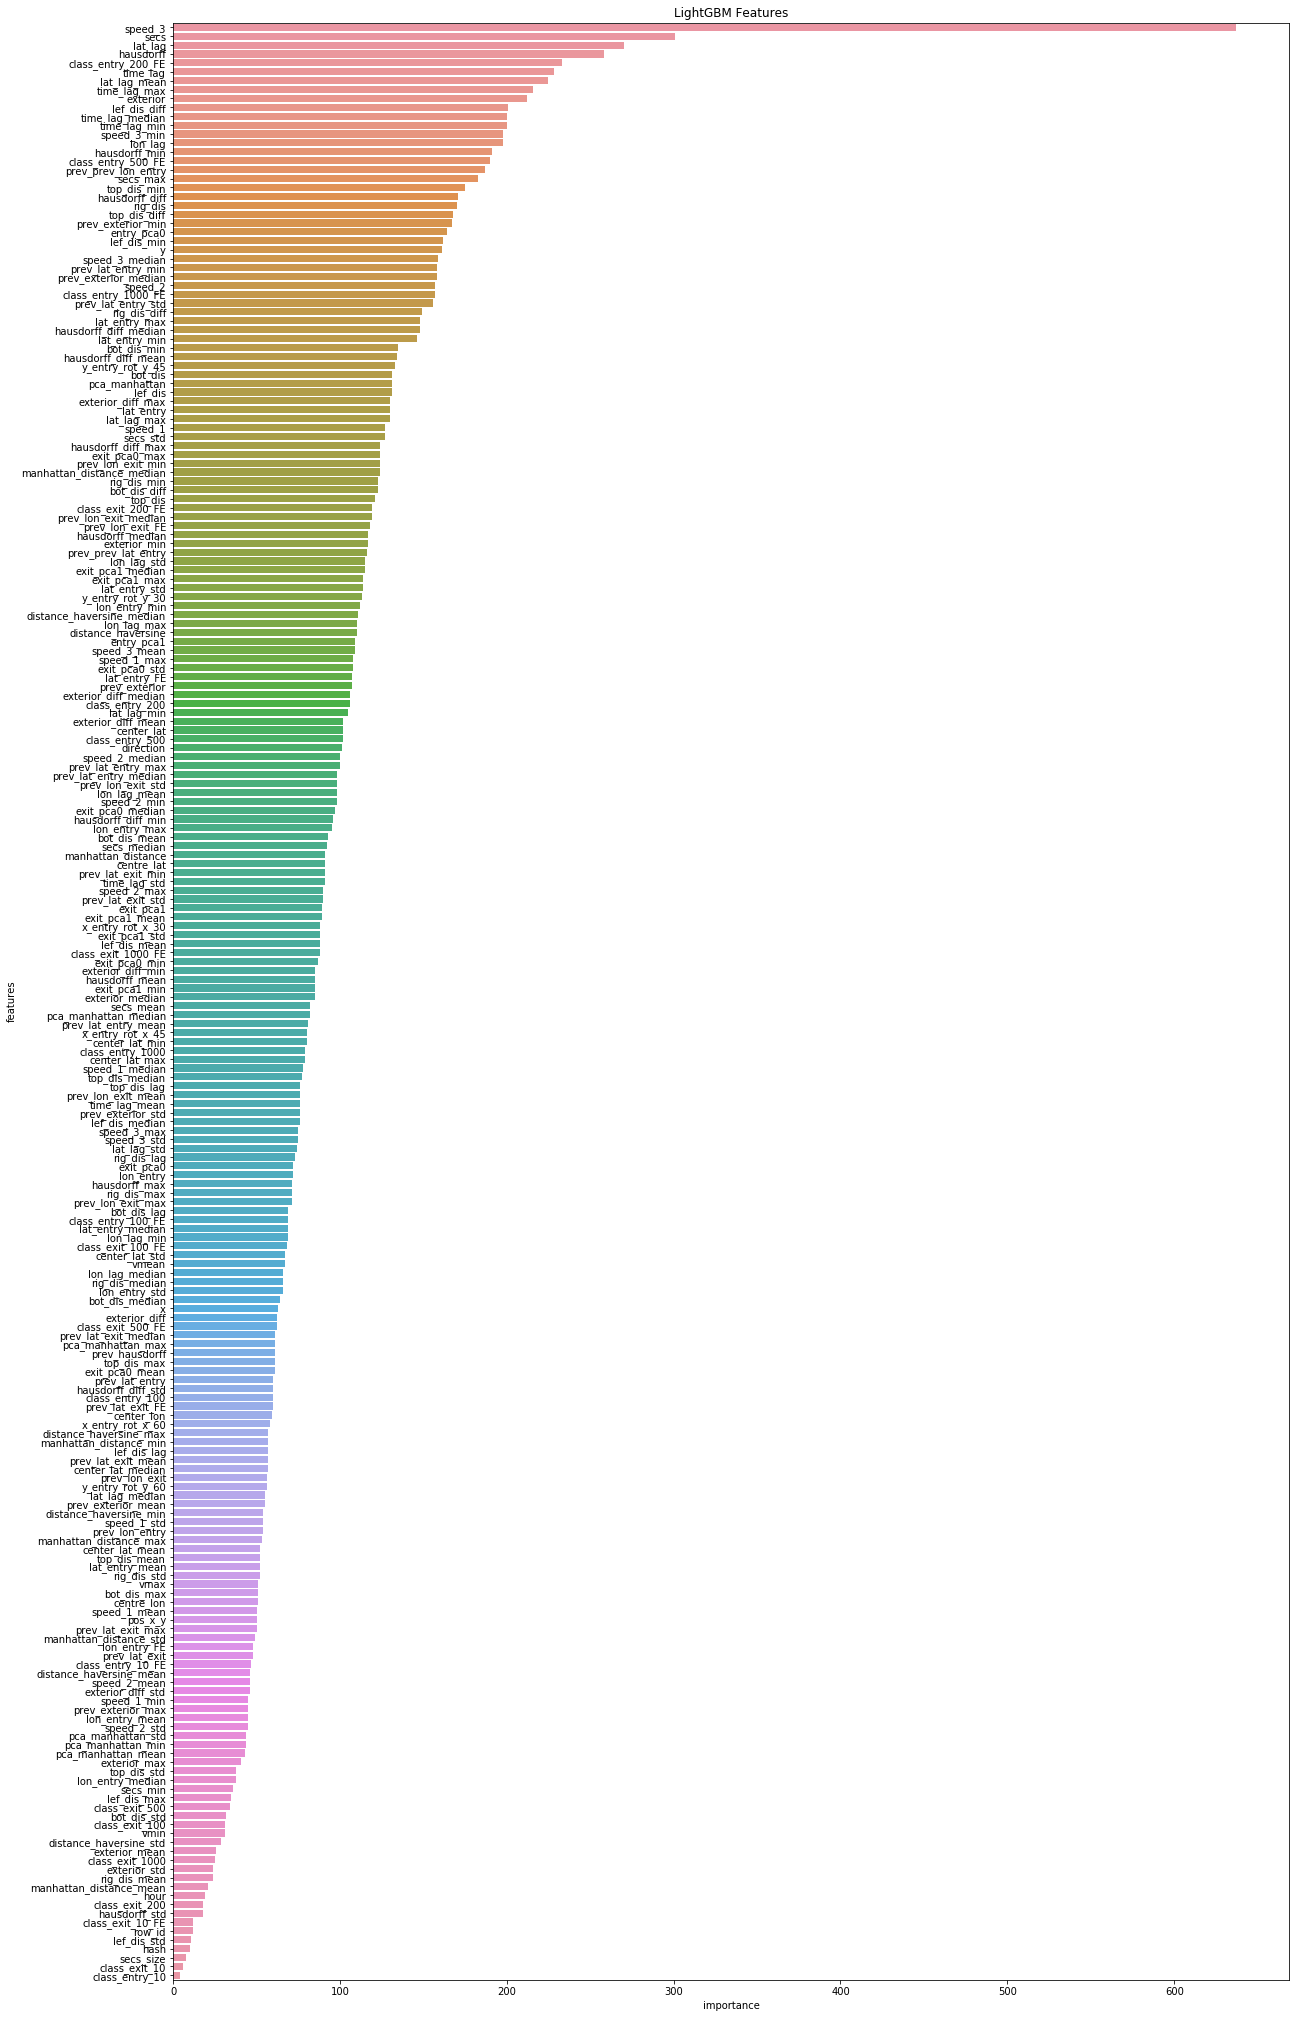

In [39]:
plt.figure(figsize=(20,36))
sns.barplot(x="importance", y="features", 
            data=importance_df.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features')
plt.show()

Below, I demonstrate that having frequency encoding for the `lon_lat_features` is beneficial for `lightgbm` because it is unable to capture the spikes in the orange bar. The only way for tree algorithms to capture such spikes is by performing a frequency encoding for the variables.

first: 24687.0, last: 36868.0


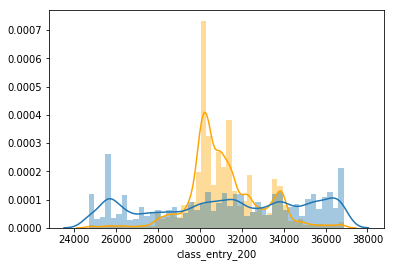

first: 43.0, last: 7450.0


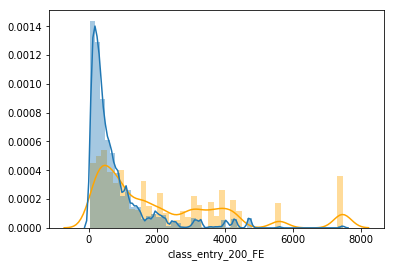

In [40]:
df = pd.concat([val_df, test_df])

l = ['class_entry_200', 'class_entry_200_FE']

for var in l:
    sample = df[[var, 'in_city']]

    sample = sample.fillna(-1)
    
    # set outliers to the 1st and 99th quantile
    # winsorization
    last_quant = sample[var].quantile(.99)
    first_quant = sample[var].quantile(.01)
    
    print('first: {}, last: {}'.format(first_quant, last_quant))

    sample.loc[sample[var] > last_quant, var] = last_quant
    sample.loc[sample[var] < first_quant, var] = first_quant
    
    plt.figure(figsize=(6,4))
    sns.distplot(sample[sample['in_city']==1][var],color='orange',) 
    sns.distplot(sample[sample['in_city']==0][var],)
    plt.show()

# Prediction
Convert the predictions to binary variables before writing to csv file.

In [41]:
output = pd.DataFrame()

ids = test_df['trajectory_id']
preds = (lgb_oof_test > THRESHOLD).astype(int)

output['id'] = ids
output['target'] = preds

output.head()

,id,target
4,traj_00032f51796fd5437b238e3a9823d13d_31_5,0
7,traj_000479418b5561ab694a2870cc04fd43_25_10,0
10,traj_000506a39775e5bca661ac80e3f466eb_29_5,1
13,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0
17,traj_00063a4f6c12e1e4de7d876580620667_3_4,0


In [0]:
NEW_FILENAME = 'submissions/' + 'solutions' + '.csv'
output.to_csv(NEW_FILENAME, index=False)

# Challenges
It is unfortunate that I did not manage (and could not think of a way) to use the actual exit points, `x_exit` and `y_exit` as my features. 

I started using them in the first place but as expected, these are "leaked" features that the model does well in predicting them for the `train` and `validation` set but fails to generalize to the last session of the `test_data`.

# What did not work
* `XGBoostRegressor` to predict `exit_lat` and `exit_lon`
* Neural network, especially `RNN` that I thought would take previous sessions into account while making a prediction
* Excessive feature encoding
* Stacking with 10 different classifiers from `sklearn`, such as `Bagging`, `RandomForest`, `ExtraTrees`, and others.
* `Catboost` and `XGBoost`
* Data augmentation by including `KNeighbors` of 3 points in the `train` set for each point in the `test` set and adding random noise



In [43]:
gc.collect()

54212